# Q1


*   In this question we want to use POS-tagged training set to compute for each word the tag that maximizes $p(t|w)$.
*   We will implement a simple tokenizer to deal with sentence boundaries.
*   We start by assuming that all unknown words are NN and compute error rate on known and unknown words.
*   Then write at least five rules to do a better job of tagging unknown words, and show the difference in error rates.

1- Suffix-based Rule: If an unknown word ends with "-ly", it is likely an adverb (RB).<br>
2- Prefix-based Rule: If an unknown word starts with a capital letter, it is likely a proper noun (NNP).<br>
3- Length-based Rule: If an unknown word is short (e.g., 1 or 2 characters), it is likely a preposition (IN) or a determiner (DT).<br>
4- Context-based Rule: If an unknown word appears after a verb (VB), it might be a gerund (VBG) or a past participle (VBN).<br>
5- Frequency-based Rule: If an unknown word frequently appears with a certain tag in the training data, assign that tag to it.


In [3]:
import re
import math

import nltk
nltk.download('brown')
from nltk.corpus import brown
import matplotlib.pyplot as plt

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
def generate_dict(_samples):
    """
    Generate a dictionary that captures the count of each (word, tag) combination from a list of samples.

    Args:
    _samples (list): List of tuples containing (word, tag) pairs.

    Returns:
    dict: A dictionary where keys are words and values are lists of dictionaries with 'tag' and 'count' keys.
          Each dictionary in the list represents a unique tag associated with the word and its count.
    """

    dictionary = {}

    for word, tag in _samples:
        if word not in dictionary:
            dictionary[word] = []

        found = False
        for item in dictionary[word]:
            if item['tag'] == tag:
                item['count'] += 1
                found = True
                break

        if not found:
            dictionary[word].append({'tag': tag, 'count': 1})

    # Sort the counts in descending order for each word
    for item in dictionary.values():
        item.sort(key=lambda x: x['count'], reverse=True)

    return dictionary

# Example usage:
_samples = [('apple', 'fruit'), ('banana', 'fruit'), ('apple', 'fruit'), ('apple', 'color'), ('banana', 'color')]
result = generate_dict(_samples)
print(result)


{'apple': [{'tag': 'fruit', 'count': 2}, {'tag': 'color', 'count': 1}], 'banana': [{'tag': 'fruit', 'count': 1}, {'tag': 'color', 'count': 1}]}


In [10]:
def predict_tag(_test_set, _tag_dict):
    """
    Predicts the tags for a given test set of words based on a provided tag dictionary.

    Args:
    _test_set (list): A list of tuples containing (word, true_tag) pairs to be predicted.
    _tag_dict (dict): A dictionary containing words as keys and lists of dictionaries with 'tag' and 'count' keys as values.

    Returns:
    float: The accuracy of the predictions, calculated as the ratio of correct predictions to the total number of predictions.

    Comments:
    - For unknown words, 'NN' (noun) tag is assigned.
    - Tags are assigned based on the highest count for known words.
      - If there are more than 1 tag for a given word, the tag with the highest count is chosen.
      - If there is only 1 tag available, it is returned directly.
    """

    correct_predictions = 0
    for word, true_tag in _test_set:
        if word in _tag_dict:
            # Get the list of tag dictionaries for the word
            tag_list = _tag_dict[word]
            # If there are multiple tags, choose the one with the highest count
            if len(tag_list) > 1:
                predicted_tag = max(tag_list, key=lambda x: x['count'])['tag']
            else:
                predicted_tag = tag_list[0]['tag']  # If only one tag, return it directly
        else:
            # Assign 'NN' as the tag for unknown words
            predicted_tag = 'NN'

        if predicted_tag == true_tag:
            correct_predictions += 1

    accuracy = correct_predictions / len(_test_set)
    print("Assuming that all unknown words are NN")
    print(f">> accuracy: {accuracy}")
    return accuracy

In [11]:
def predict_tag_with_improvements(_test_set, _tag_dict):
    """
    Predicts the tags for a given test set of words based on a provided tag dictionary, with additional rules for unknown words.

    Args:
    _test_set (list): A list of tuples containing (word, true_tag) pairs to be predicted.
    _tag_dict (dict): A dictionary containing words as keys and lists of dictionaries with 'tag' and 'count' keys as values.

    Returns:
    float: The accuracy of the predictions, calculated as the ratio of correct predictions to the total number of predictions.

    Comments:
    - For unknown words, 'NN' (noun) tag is initially assigned.
    - Additional rules are applied to analyze unknown words and assign more specific tags based on patterns observed in the word:
        - 'VBG' (verb, gerund) for words ending in 'ing'
        - 'NP$' (noun, possessive) for words ending in "'s"
        - 'NNS' (noun, plural) for words ending in 's'
        - 'RB' (adverb) for words ending in 'ly'
        - 'VBN' (verb, past participle) for words ending in 'ed'
        - 'JJ' (adjective) for words matching certain patterns like 'ble', 'ish', 'ful', etc.
        - 'CD' (cardinal numeral) for numeric strings
        - 'NP' (noun, proper singular) for capitalized words
    """

    accuracy = 0
    total_predictions = 0
    correct_predictions = 0

    for word, true_tag in _test_set:
        total_predictions += 1
        if word in _tag_dict:
            # Get the list of tag dictionaries for the word
            tag_list = _tag_dict[word]
            # If there are multiple tags, choose the one with the highest count
            if len(tag_list) > 1:
                predicted_tag = max(tag_list, key=lambda x: x['count'])['tag']
            else:
                predicted_tag = tag_list[0]['tag']  # If only one tag, return it directly
        else:
            # Apply additional rules for unknown words
            if word.endswith('ing'):
                predicted_tag = 'VBG'  # verb, gerund
            elif word.endswith("'s"):
                predicted_tag = 'NP$'  # noun, possessive
            elif word.endswith('s'):
                predicted_tag = 'NNS'  # noun, plural
            elif word.endswith('ly'):
                predicted_tag = 'RB'  # adverb
            elif word.endswith('ed'):
                predicted_tag = 'VBN'  # verb, past participle
            elif any(word.endswith(suffix) for suffix in ['ble', 'ish', 'ful']):
                predicted_tag = 'JJ'  # adjective
            elif word.isdigit():
                predicted_tag = 'CD'  # cardinal numeral
            elif word[0].isupper():
                predicted_tag = 'NP'  # noun, proper singular
            else:
                predicted_tag = 'NN'  # noun by default for unknown words

        if predicted_tag == true_tag:
            correct_predictions += 1

    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
    print(f"With additional rules for unknown words")
    print(f">> accuracy: {accuracy}")
    return accuracy


In [20]:
CORPUS = brown.tagged_words(categories='news')
CORPUS_SIZE = len(brown.tagged_words(categories='news'))

CUT_OFF = math.floor(CORPUS_SIZE * 0.75)

# section off training and testing lists from corpus
training_list = CORPUS[:CUT_OFF]
testing_list = CORPUS[CUT_OFF:]

# duplicates are ignored in sets
training_set = set(training_list)
testing_set = set(testing_list)
intersection = training_set.intersection(testing_set)

print(f"length of training set:     {len(training_list)}")
print(f"length of testing set:      {len(testing_list)}")

# uncomment to see how much the training set and testing set overlap
print(f"intersection:               {len(intersection)}")

# uncomment to survey tagged corpus
print(training_set)

tag_dict = generate_dict(training_list)
accurary_base = predict_tag(testing_list, tag_dict)
accurary_impr = predict_tag_with_improvements(testing_list, tag_dict)
delta = math.floor((accurary_impr - accurary_base) * len(testing_list))
print(f"{delta} more words got correctly classified.")


length of training set:     75415
length of testing set:      25139
intersection:               3429
{('programs', 'NNS'), ('authoritative', 'JJ'), ('Col.', 'NN-TL'), ('golden', 'JJ'), ('filly', 'NN'), ('reformatory', 'NN'), ('better', 'JJR'), ('escaping', 'VBG'), ('56-yard', 'JJ'), ('butter', 'NN'), ('Theatre', 'NN-TL'), ('him', 'PPO'), ('tripled', 'VBD'), ('addresses', 'NNS'), ('$100', 'NNS'), ('1,000', 'CD'), ('Dorenzo', 'NP'), ('invitation', 'NN'), ('century', 'NN'), ('earrings', 'NNS'), ('jeopardizing', 'VBG'), ('Rudolph', 'NP'), ('fiery', 'JJ'), ('force', 'NN'), ('77', 'CD-TL'), ('homers', 'NNS'), ('churches', 'NNS'), ('Patty', 'NP-TL'), ('losing', 'VBG'), ('Vice-President', 'NN-TL'), ('Wyman', 'NP'), ('Cauffman', 'NP'), ('studied', 'VBN'), ('nurse', 'NN'), ('infiltrating', 'VBG'), ("Dealers'", 'NNS$-HL'), ('Texans', 'NPS'), ('early-season', 'NN'), ('percentages', 'NNS'), ('avid', 'JJ'), ('alive', 'JJ'), ('Retail', 'JJ-TL'), ('troops', 'NNS'), ('news', 'NN'), ('Vernava', 'NP'), (

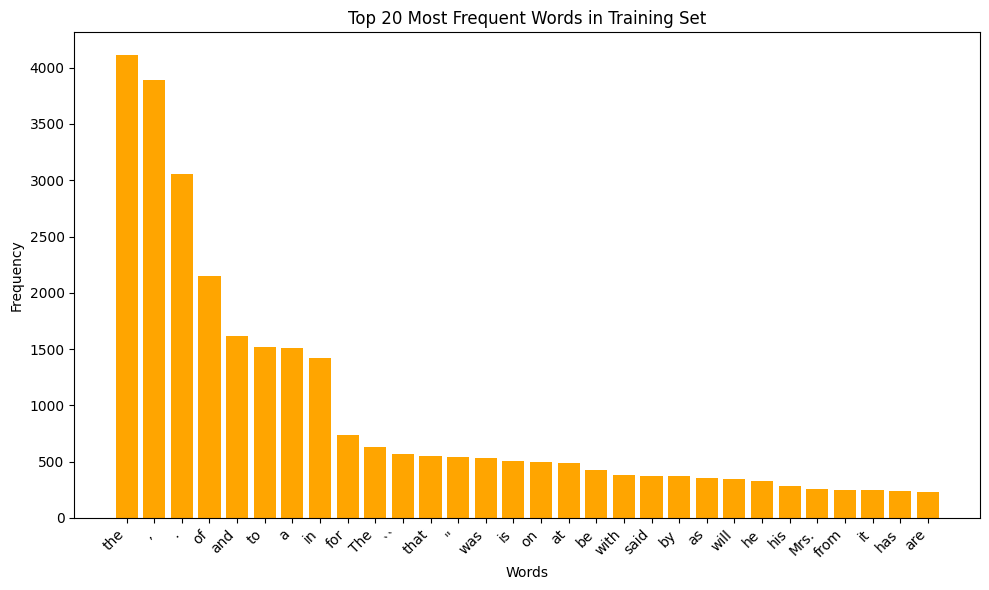

In [23]:
# Create a dictionary to store the count of each word
word_count = {}
for word, _ in training_list:
    if word in word_count:
        word_count[word] += 1
    else:
        word_count[word] = 1

# Sort the dictionary based on the count of each word
sorted_word_count = sorted(word_count.items(), key=lambda x: x[1], reverse=True)

# Extract words and counts for plotting
words = [item[0] for item in sorted_word_count]
counts = [item[1] for item in sorted_word_count]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(words[:30], counts[:30], color='orange')
plt.title('Top 20 Most Frequent Words in Training Set')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
